# Code for sctype: SVM and ANN trained with Zheng 68k PBMC dataset

### (10-15-2020)
- initializing the sctype class imports 10Xv2 data with genes.tsv, barcodes.tsv, and matrix.mtx files
- must provide path to the directory with these three files.
- Need to import cell type annotations manually with pd.read_csv()

### (10-19-2020)
- SVM implemented with LinearSVC 
    - SVC was giving me "AttributeError: var not found"
    - Not sure how to resolve this error, but documentation recommends LinearSVC for large datasets anyways
- changed the output of train_test_split() to split all train/test data as well as labels (4 outputs)

### (10-20-2020)
- Added CalibratedClassifierCV() wrapper to model to calibrate probabilities
- Use predict_proba() method to get probabilities for each class

### (10-22-2020)
- implementing ANN with Tensorflow/Keras instead of PyTorch

### (10-23-2020)
- tried 10 epochs w/ 16 (instead of 500) as batch size. Still about 23% accuracy on test data.
- removing dropouts in the init method and added method for normalization/scaling
- note: removing all genes with 0 counts and using normalized logCPM does not improve test accuracy
- Realized that using to_categorical separately on train/test data mixes up the labels.
- one 200 node layer gives about 65% accuracy on test data

### (10-24-2020)
- created method to convert binary class matrices back to class vectors 
- class vectors can now be used to create confusion matrices (true labels, predicted labels)
- created method to take the max. probability cell type assignment from model.predict as the cell type prediction
- Added demo and general workflow summary

In [1]:
import numpy as np
import pandas as pd
import scipy.io as io
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

# path = path to the 10Xv2 data directory containing genes.tsv, barcodes.tsv, and matrix.mtx files
# Note: need to import cell type annotations file manually since annotation files do not 
# have any set format between datasets. Set index names to cell barcode IDs in the annotation dataframe
# and have the celltype annotations as the first column.

class sctype:
    def __init__(self, path):
        self.genes = pd.read_csv(path + 'genes.tsv', sep = '\t', header = None).iloc[:,1]
        self.barcodes = pd.read_csv(path + 'barcodes.tsv', sep = '\t', header = None).iloc[:,0]
        expression = io.mmread(path + 'matrix.mtx') 
        
        data = pd.DataFrame.sparse.from_spmatrix(data = expression, index = self.genes, columns = self.barcodes)
        data = data.fillna(0)
        gene_counts = data.sum(axis = 1)
        data = data[gene_counts != 0]
        
        self.data = data.transpose()
        self.dropouts = gene_counts[gene_counts == 0].index
    
    
# This preprocess step will divide the gene counts by the total counts per cell, multiply by scale_factor
# and perform log1p; output is normalized logCPM data. 
# Scale will center the per gene expression data around 0 and adjust to unit variance.
# Though, this doesn't seem to affect NN performance too much. Can feed self.data to the split method
# and go directly to training the NN without running this preprocessing step.

    def data_preprocess(self, normalize = True, scale_factor = 10000, scale = True):
        if normalize:
            cell_counts = self.data.sum(axis = 1)
            div = self.data.divide(other = cell_counts, axis = 'index')
            self.data_norm = np.log1p(div * scale_factor)
        if scale:
            if normalize:
                self.data_norm = (self.data_norm - np.mean(self.data_norm, axis = 0))\
                /(np.std(self.data_norm, axis = 0))
            else:
                self.data_scaled = (self.data - np.mean(self.data, axis = 0))\
                /(np.std(self.data, axis = 0))

                
# Labels input should be a dataframe with celltype annotations in the first column. 
# This method will convert labels with one-hot encoding for use as labels in the NN.
# Must be done BEFORE splitting into train/test sets.

# The key to the one-hot encoded labels will be stored in self.key
# The original labels will be stored in self.labels

    def process_labels(self, labels, depth):
        all_labels = labels.copy()
        
        if depth == 1:
            all_labels[all_labels == ['CD4+/CD45RO+ Memory']] = 'CD4+ T' 
            all_labels[all_labels == ['CD4+/CD25 T Reg']] = 'CD4+ T' 
            all_labels[all_labels == ['CD4+ T Helper2']] = 'CD4+ T' 
            all_labels[all_labels == ['CD4+/CD45RA+/CD25- Naive T']] = 'CD4+ T' 
            all_labels[all_labels == ['CD8+ Cytotoxic T']] = 'CD8+ T'
            all_labels[all_labels == ['CD8+/CD45RA+ Naive Cytotoxic']] = 'CD8+ T'
        
            factorized = pd.factorize(all_labels.iloc[:,0])
            self.labels = all_labels.iloc[:,0]
            self.key = factorized[1]
            self.categorical_labels = to_categorical(factorized[0], len(factorized[1]))
        
        if depth == 2:
            factorized = pd.factorize(all_labels.iloc[:,0])
            self.labels = all_labels.iloc[:,0]
            self.key = factorized[1]
            self.categorical_labels = to_categorical(factorized[0], len(factorized[1]))
    
    
# NOTE: for SVM, it is better to use data that is NOT scaled; it will take too long to train.
# Only use self.data_norm to split if scale = False when calling self.data_preprocess(). 
# Otherwise, use data = self.data

    def split(self, data, labels, test_size, random_state):
        self.train_data, self.test_data, self.train_labels, self.test_labels = train_test_split(
            data, labels, test_size=test_size,
            random_state=random_state, stratify=labels)

        
    def svm(self, iterations = 1000, cv = 4, method = 'sigmoid'):
        train_labels = self.to_vector(self.train_labels)
        
        clf = LinearSVC(max_iter = iterations)
        clf = CalibratedClassifierCV(clf, cv = cv, method = method)
        self.svmfit = clf.fit(self.train_data, train_labels)
        return self.svmfit
    
    
    def evaluate_svm(self, predictions, target):
        true_labels = self.to_vector(target)
        acc = sum(predictions == true_labels)/len(predictions)
        return acc
    
    
    def ann(self, epochs, batch_size):
        model = keras.Sequential()
        model.add(layers.Dense(200, activation='relu', name = 'layer1'))
        model.add(layers.Dense(100, activation='relu', name = 'layer2'))
        model.add(layers.Dense(len(self.key), activation='softmax', name = 'outputlayer'))
        
        model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
    
        model.fit(self.train_data, self.train_labels, epochs=epochs, batch_size=batch_size)
            
        self.ann_fit = model
        return self.ann_fit
    
    
# From the output of NN, select highest probabilities per cell as the celltype prediction

    def max_prob(self, probs):
        predictions = (probs == probs.max(axis = 1)[:,None]).astype(int)
        return predictions
    
    
# Converts the binary class matrix (output from NN) back to a class vector with
# integeters representing the different classes. (essentially undoes to_categorical)
# The order of the labels are stored in self.key

    def to_vector(self, class_matrix):
        copy_matrix = class_matrix.copy()
        for i in range(len(copy_matrix[0])):
            copy_matrix[:,i] = copy_matrix[:,i] * (i+1)
        tmp = []
        for j in range(len(copy_matrix)):
            tmp.append(np.trim_zeros(copy_matrix[j]))
        class_vector = np.concatenate(tmp)
        return class_vector

## Importing/processing data
1. __Define path to annotation and data files__ (in format of 10X v2 data with genes.tsv, barcodes.tsv, and matrix.mtx files)
2. __import and process annotation file__ to have barcodes as indices and cell type labels in first column
3. __Create sctype object__, given the path to the data files
4. __Process the labels__; this will create self.labels which retains original annotation information, but also creates one-hot encoded labels to be used for the neural network. self.key has all of the unique cell types being annotated. NOTE: Setting scale = True seems to dramatically increase train time with the SVM, so either run with normalize = True, scale = False OR skip entirely and train SVM with self.data (raw counts).
5. __Preprocess counts data__(optional); this doesn't seem to have much of an affect with this intra-dataset evaluation on test data. But this will divide counts by total counts per cell, log-normalize (with log1p), and center feature data around 0.
6. __Split the data__ to create separate train/test datasets with respective labels

In [2]:
# 1 and 2. Define annotation and data file paths and import labels. 

path_data = '/Users/leealj/py_projects/biof509_final/zheng68k/filtered_matrices_mex/hg19/'
path_anno = '/Users/leealj/py_projects/biof509_final/zheng68k/'

labels = pd.read_csv(path_anno + '68k_pbmc_barcodes_annotation.tsv', sep = '\t').loc[:,["barcodes","celltype"]]
labels.set_index("barcodes", inplace = True)

In [3]:
# 3 and 4. Create sctype object, given path to the data files and process labels

zheng = sctype(path_data)
zheng.process_labels(labels, depth = 1)

In [4]:
# 5. Data pre-processing step to calculate logCPM counts and center around 0 with unit variance.

zheng.data_preprocess(normalize = True, scale = False)

In [5]:
# 6. Split the expression data into a train set and test set with their respective labels

zheng.split(data = zheng.data_norm, labels = zheng.categorical_labels, test_size = 0.25, random_state = 20)

## Train and generate predictions with ANN
1. __Train the NN__ with # of epochs and batch size provided as input to the self.ann() method.
2. __Evaluate performance of NN__
3. __Generate cell type predictions__ with self.ann_fit.predict()
4. __Convert prediction probabilities to cell type labels__ with self.max_prob followed by self.to_vector. This will provide a class vector with each integeter representing a cell type (actual cell type names stored in self.key)

In [6]:
# 1. train the NN with the training dataset from split

zheng.ann(5, 32) 

Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1608/1608 [==============================] - 30s 19ms/step - loss: 0.4537 - accuracy: 0.8156
Epoch 2/5
1608/1608 [==============================] - 32s 20ms/step - loss: 0.2283 - accuracy: 0.9078
Epoch 3/5
1608/1608 [==============================] - 31s 19ms/step - loss: 0.1348 - accuracy: 0.9460
Epoch 4/5
1608/1608 [==============================] - 30s 19ms/step - loss: 0.0805 - accuracy: 0.9696
Epoch 5/5
1608/1608 [==============================] - 32s 20ms/step - loss: 0.0547 - accuracy: 

In [7]:
# 2. Use train dataset from split to test the NN

score_train = zheng.ann_fit.evaluate(zheng.train_data, zheng.train_labels, verbose=1)
score_test = zheng.ann_fit.evaluate(zheng.test_data, zheng.test_labels, verbose=1)

print('training loss=', score_train[0]) 
print('training accuracy=', score_train[1])
print('test loss=', score_test[0]) 
print('test accuracy=', score_test[1]) 

536/536 [==============================] - 2s 4ms/step - loss: 0.6469 - accuracy: 0.8454
training loss= 0.0326714850962162
training accuracy= 0.9882568120956421
test loss= 0.6468686461448669
test accuracy= 0.8453776836395264


In [8]:
# 3. Make the cell type predictions with trained NN

NNtest_probs = zheng.ann_fit.predict(zheng.test_data)

In [9]:
# 4. Select highest probabilities per cell from NN as the cell type prediction

NNtest_true = zheng.to_vector(zheng.test_labels)
NNtest_pred = zheng.to_vector(zheng.max_prob(NNtest_probs))
print(np.unique(NNtest_pred))
print(zheng.key)

[1 2 3 4 5 6 7]
Index(['CD8+ T', 'CD4+ T', 'CD19+ B', 'CD56+ NK', 'CD34+', 'Dendritic',
       'CD14+ Monocyte'],
      dtype='object')


In [10]:
# # Cell type probabilities split by true cell type labels
# # to be used for violin plots

# predict1 = NNtest_probs[np.where(NNtest_true == 1)]
# predict2 = NNtest_probs[np.where(NNtest_true == 2)]
# predict3 = NNtest_probs[np.where(NNtest_true == 3)]
# predict4 = NNtest_probs[np.where(NNtest_true == 4)]
# predict5 = NNtest_probs[np.where(NNtest_true == 5)]
# predict6 = NNtest_probs[np.where(NNtest_true == 6)]
# predict7 = NNtest_probs[np.where(NNtest_true == 7)]

### Generating heatmaps and violin plots for ANN

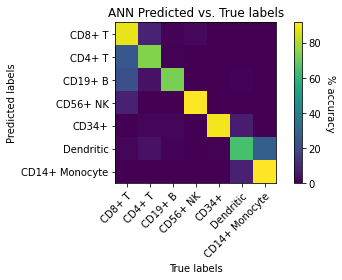

In [11]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

confmatrix_NN1 = confusion_matrix(NNtest_true, NNtest_pred, normalize = 'true')

fig, ax = plt.subplots()
im = ax.imshow(confmatrix*100)

ax.set_xticks(np.arange(len(zheng.key)))
ax.set_yticks(np.arange(len(zheng.key)))

ax.set_xticklabels(zheng.key)
ax.set_yticklabels(zheng.key)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("% accuracy", rotation=-90, va="bottom")

ax.set_ylabel("Predicted labels")
ax.set_xlabel("True labels")
ax.set_title("ANN Predicted vs. True labels")
fig.tight_layout()
# plt.savefig(fname = '/Users/leealj/py_projects/biof509_final/plots/nn_heatmap.png', dpi = 500, transparent = True)
plt.show()

In [12]:
# # Generate visualize of the ANN model

# keras.utils.plot_model(
#     zheng.ann_fit,
#     to_file="/Users/leealj/py_projects/biof509_final/model.png",
#     dpi=96,
# )

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [13]:
# NNtest_probs[np.where(NNtest_true == 2)][0]

array([1.5932193e-02, 9.8269904e-01, 1.3682611e-03, 1.4907837e-10,
       2.5075900e-07, 1.9705588e-07, 2.5712943e-09], dtype=float32)

In [14]:
# [np.where(NNtest_pred) == 1] # Indices of all cells that were predicted to be CD8+ T
# NNtest_probs[np.where(NNtest_pred) == 1] # Prediction probabilities (for all cell types) of all cells that were predicted to be CD8+ T
# # plot these values on violin plot... So there will be 7 violin plots in total.

NameError: name 'NNtest_prob' is not defined

## Train and generate predictions with SVM
1. __Train the SVM__ with cv set to number of folds for cross validation used to optimize and calibrate the probabilities that are returned as output from model.predict().
2. __Generate cell type predictions__ with model.predict()
3. __Evaluate performance of SVM__ with self.evaluate_svm() using the output from model.predict() and the true labels (from self.train_labels or self_test_labels) as the input.
4. __Convert prediction probabilities to cell type labels__ with self.max_prob followed by self.to_vector. This will provide a class vector with each integeter representing a cell type (actual cell type names stored in self.key)

In [15]:
# 1. Train the SVM: Using the same train/test data that was used with the NN for a proper comparison

model = zheng.svm()

/Users/leealj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/leealj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/leealj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/leealj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [16]:
# 2. Generate cell type predictions

SVMtrain_pred = model.predict(zheng.train_data)
SVMtest_pred = model.predict(zheng.test_data)

In [17]:
# 3. Evaluate performance of SVM

# print(zheng.evaluate_svm(predictions = SVMtrain_pred, target = zheng.train_labels))
# print(zheng.evaluate_svm(predictions = SVMtest_pred, target = zheng.test_labels))

true_train = zheng.to_vector(zheng.train_labels)
true_test = zheng.to_vector(zheng.test_labels)

print("The prediction accuracy on the train set is: {}"\
      .format(sum(SVMtrain_pred == true_train)/len(SVMtrain_pred)))
print("The prediction accuracy on the test set is: {}"\
      .format(sum(SVMtest_pred == true_test)/len(SVMtest_pred)))

The prediction accuracy on the train set is: 0.9588987829062487
The prediction accuracy on the test set is: 0.8517935258092738


In [18]:
SVMtest_probs = model.predict_proba(zheng.test_data)
SVMtest_probs

array([[5.13164340e-01, 1.56310852e-01, 2.96912804e-01, ...,
        2.19540014e-03, 6.09923665e-04, 2.66411064e-03],
       [9.63507496e-01, 1.04110069e-02, 2.03729462e-02, ...,
        1.98127791e-04, 2.98344098e-03, 2.48717946e-03],
       [9.87258685e-01, 2.67217142e-03, 9.37881546e-05, ...,
        2.15381944e-04, 9.34770567e-03, 1.70668056e-04],
       ...,
       [9.76803260e-01, 1.88961322e-02, 5.25206549e-05, ...,
        6.94294996e-05, 1.27399502e-04, 1.52357323e-03],
       [6.03959902e-01, 8.81168541e-02, 2.92858655e-01, ...,
        2.70043015e-04, 1.22739054e-02, 5.60454554e-04],
       [9.46421958e-01, 2.11357967e-02, 2.34827202e-02, ...,
        5.42281363e-03, 1.63222449e-03, 1.56427311e-03]])

### Generate heatmaps and violin plots for SVM

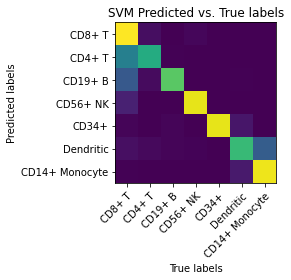

In [19]:
confmatrix_SVM = confusion_matrix(zheng.to_vector(zheng.test_labels), SVMtest_pred, normalize = 'true')

fig2, ax2 = plt.subplots()
im = ax2.imshow(confmatrix_SVM*100)

ax2.set_xticks(np.arange(len(zheng.key)))
ax2.set_yticks(np.arange(len(zheng.key)))

ax2.set_xticklabels(zheng.key)
ax2.set_yticklabels(zheng.key)

plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

cbar = ax2.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("% accuracy", rotation=-90, va="bottom")

ax2.set_ylabel("Predicted labels")
ax2.set_xlabel("True labels")
ax2.set_title("SVM Predicted vs. True labels")
fig2.tight_layout()
# plt.savefig(fname = '/Users/leealj/py_projects/biof509_final/plots/svm_heatmap.png', dpi = 500, transparent = True)
plt.show()

# Analysis with depth = 2
- Attempting to distinguish between T-cell subsets 

In [20]:
# Re-run the process_labels() method, but with depth = 2 to retain T-cell subset identities
# and split data again with these labels.

zheng.process_labels(labels, depth = 2)
zheng.split(data = zheng.data_norm, labels = zheng.categorical_labels, test_size = 0.25, random_state = 20)

In [21]:
# Train another ANN

d2_ann = zheng.ann(5, 32) 

Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1608/1608 [==============================] - 30s 19ms/step - loss: 0.8051 - accuracy: 0.6897
Epoch 2/5
1608/1608 [==============================] - 33s 20ms/step - loss: 0.4321 - accuracy: 0.8348
Epoch 3/5
1608/1608 [==============================] - 31s 20ms/step - loss: 0.2345 - accuracy: 0.9139
Epoch 4/5
1608/1608 [==============================] - 32s 20ms/step - loss: 0.1327 - accuracy: 0.9507
Epoch 5/5
1608/1608 [==============================] - 31s 20ms/step - loss: 0.0900 - accuracy: 

In [23]:
# 2. Use train dataset from split to test the NN

score_train2 = d2_ann.evaluate(zheng.train_data, zheng.train_labels, verbose=1)
score_test2 = d2_ann.evaluate(zheng.test_data, zheng.test_labels, verbose=1)

print('training loss=', score_train2[0]) 
print('training accuracy=', score_train2[1])
print('test loss=', score_test2[0]) 
print('test accuracy=', score_test2[1]) 

536/536 [==============================] - 2s 4ms/step - loss: 1.4008 - accuracy: 0.7383
training loss= 0.12273262441158295
training accuracy= 0.9530077576637268
test loss= 1.4007900953292847
test accuracy= 0.7383493781089783


In [ ]:
NNtest_probs2 = d2_ann.predict(zheng.test_data)
NNtest_true2 = zheng.to_vector(zheng.test_labels)
NNtest_pred2 = zheng.to_vector(zheng.max_prob(NNtest_probs2))
print(np.unique(NNtest_pred2))
print(zheng.key)

In [ ]:
confmatrix_NN2 = confusion_matrix(NNtest_true2, NNtest_pred2, normalize = 'true')

fig, ax3 = plt.subplots()
im = ax3.imshow(confmatrix*100)

ax3.set_xticks(np.arange(len(zheng.key)))
ax3.set_yticks(np.arange(len(zheng.key)))

ax3.set_xticklabels(zheng.key)
ax3.set_yticklabels(zheng.key)

plt.setp(ax3.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

cbar = ax3.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("% accuracy", rotation=-90, va="bottom")

ax3.set_ylabel("Predicted labels")
ax3.set_xlabel("True labels")
ax3.set_title("ANN Predicted vs. True labels (depth=2)")
fig.tight_layout()
# plt.savefig(fname = '/Users/leealj/py_projects/biof509_final/plots/nn2_heatmap.png', dpi = 500, transparent = True)
plt.show()